In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the data

As in previous exercises, we will train a regression model to predict a person's weight from their height. The model is linear regression with one explanatory variable (weight) and an offset. The model is optimized under a least-squares loss. The variable $b$ contains the prediction targets (a vector of the length of the dataset) and the variable $A$ is the data matrix, containing (1) a column of ones and (2) a column with the explanatory variable.

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    # Clone the entire repo to access the files.
    !git clone -l -s https://github.com/epfml/OptML_course.git cloned-repo
    %cd cloned-repo/labs/ex05/template/

In [3]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
b, A = build_model_data(x, weight)

In [4]:
b.shape, A.shape

((10000,), (10000, 2))

# Least Squares Estimation
Least squares estimation is one of the fundamental machine learning algorithms. Given an $ n \times d $ matrix $A$ and a $ n \times 1$ vector $b$, the goal is to find a vector $x \in \mathbb{R}^d$ which minimizes the objective function $$f(x) = \frac{1}{2n} \sum_{i=1}^{n} (a_i^\top x - b_i)^2 = \frac{1}{2n} \|Ax - b\|^2 $$

In this exercise, we will try to fit $x$ using Least Squares Estimation. 

One can see the function is $\mu$ strongly convex with $\mu = \lambda_{max}(\nabla^2 f(x))$ and $L$ smooth with $L = \lambda_{min}(\nabla^2 f(x)$ everywhere, since here the Hessian matrix is constant, independent of $x$.



# Stochastic Gradient Descent

Please fill in the function `minibatch_gradient` below:

In [5]:
def minibatch_gradient(targets_b, data_A, params_x):
    """
    Compute a mini-batch stochastic gradient from a subset of `num_examples` from the dataset.
    
    :param targets_b: a numpy array of shape (num_examples)
    :param data_A: a numpy array of shape (num_examples, num_features)
    :param params_x: compute the mini-batch gradient at these parameters, numpy array of shape (num_features)
    
    :return: gradient: numpy array of shape (num_features)
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: implement stochastic gradient computation. It's same as the gradient descent.
    # ***************************************************
    batch_size = len(targets_b)
    err =  targets_b - data_A.dot(params_x)
    grad = -data_A.T.dot(err) / batch_size
    return grad

Verify empirically for a fixed parameter vector $x$ that the expected value of your `minibatch_gradient` function equals the full gradient. Validating this property for a mini-batch of size 1 is sufficient.

In [6]:
num_trials = 10
for i in range(num_trials):
    # Try different parameter vectors $x$
    x = np.random.rand(A.shape[1])

    # Compute the mean of all stochastic gradient for mini-batch size 1
    stochastic_gradients = []
    for i in range(len(b)):
        stochastic_gradients.append(minibatch_gradient(b[i:i+1], A[i:i+1, :], x))

    # Compute the full gradient
    full_gradient = minibatch_gradient(b, A, x)

    # Those should be the same on average
    assert np.allclose(np.mean(stochastic_gradients, axis=0), full_gradient)
    
print('Tests passed')


Tests passed


Now, implement stochastic gradient descent for Linear Least Squares, below.


In [7]:
def stochastic_gradient(targets_b, data_A, params_x, batch_size=1):
    """
    Compute a stochastic gradient
    
    :param targets_b: numpy array of size (num_examples)
    :param data_A: numpy array of size (num_examples, num_features)
    :param params_x: compute the mini-batch gradient at these parameters, numpy array of shape (num_features)
    :param batch_size: integer: number of datapoints to compute the stochastic gradient from
    
    :return: gradient, numpy array of shape (num_features)
    """
    dataset_size = len(targets_b)
    indices = np.random.choice(dataset_size, batch_size, replace=False)
    return minibatch_gradient(targets_b[indices], data_A[indices, :], params_x)

def full_objective(targets_b, data_A, params_x):
    """Compute the least squares objective over the whole dataset"""
    return 0.5 * np.mean(((data_A @ params_x) - targets_b)**2)

def stochastic_gradient_descent(
        targets_b, 
        data_A, 
        initial_x, 
        batch_size, 
        max_iters, 
        initial_learning_rate, 
        decreasing_learning_rate=False):
    """
    Mini-batch Stochastic Gradient Descent for Linear Least Squares problems.
    
    :param targets_b: numpy array of size (num_examples)
    :param data_A: numpy array of size (num_examples, num_features)
    :param initial_x: starting parameters, a numpy array of size (num_features)
    :param batch_size: size of the mini-batches
    :param max_iters: integer, number of updates to do
    :param initial_learning_rate: float
    :param decreasing_learning_rate: if set to true, the learning rate should decay linearly to 0 at max_iters
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: implement stochastic gradient descent.
    # ***************************************************
    x = initial_x.copy()
    objectives = []
    param_states = [initial_x]
    gamma = initial_learning_rate
    for iteration in range(max_iters):
        grad = stochastic_gradient(targets_b, data_A, x, batch_size)
        
        if decreasing_learning_rate:
            gamma = initial_learning_rate/(iteration+1)
        
        x -= grad*gamma
        
        objectives.append(full_objective(targets_b, data_A, x))
        param_states.append(x.copy())
#         if iteration%10 == 0 or iteration == max_iters - 1:
#             print("SGD({bi:04d}/{ti:04d}): objective = {l:10.2f}".format(
#                   bi=iteration, ti=max_iters - 1, l=objectives[-1]))
    return objectives, param_states

Now it is time to test your optimizer with a naive step size with the example code below.

In [8]:
# Define the parameters of the algorithm.
max_iters = 200
gamma = 0.2
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives, sgd_xs = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD: execution time=0.189 seconds


Time Visualization

In [9]:
from plots import gradient_descent_visualization
from ipywidgets import IntSlider, interact
from grid_search import *

# Generate grid data for visualization (parameters to be swept and best combination)
grid_x0, grid_x1 = generate_w(num_intervals=10)
grid_objectives = grid_search(b, A, grid_x0, grid_x1)
loss_star, x0_star, x1_star = get_best_parameters(grid_x0, grid_x1, grid_objectives)

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_objectives, sgd_xs, grid_objectives, grid_x0, grid_x1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_xs)))

interactive(children=(IntSlider(value=1, description='n_iter', max=201, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Better Learning Rate

## Assuming bounded expected stochastic gradients
Assume we are moving in a bounded region $\|x\| \leq 25$ containing all iterates (and we assume $\|x-x^\star\| \leq 25$ as well, for simplicity). By $\nabla f(x) = \frac{1}{n}A^\top (Ax - b)$, one can see that $f$ is Lipschitz over that bounded region, with Lipschitz constant $\|\nabla f(x)\| \leq \frac{1}{n} (\|A^\top A\|\|x\| + \|A^\top Ab\|)$. We also know that $E\big[\|g_t\|\big | x_t\big]\ = \nabla f(x)$. So to find B such that  $E\big[\|g_t\|^2\big]\leq B^2$, we need to compute the Lipschitz constant.

In [10]:
grad_norm_bound = (25*np.linalg.norm(np.dot(A.T,A)) + np.linalg.norm(np.dot(A.T,b)))/A.shape[0]

# Define the parameters of the algorithm.
max_iters = 200

gamma = 25 / (grad_norm_bound * np.sqrt(max_iters)) # Fill in a better learning rate  

batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives_dec_gamma, sgd_xs_dec_gamma = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD: execution time=0.092 seconds


Time visualization with a better learning rate

In [11]:
interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_xs_dec_gamma)))

interactive(children=(IntSlider(value=1, description='n_iter', max=201, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

## SGD using strong convexity
Try doing SGD with a better learning rate using the fact that the objective function is strongly convex.<br>
(Hint: you can use a decreasing stepsize parameter gamma in stochastic_gradient_descent.)

In [12]:
# Define the parameters of the algorithm.
max_iters = 200

# You may use these results from last week
mu = np.linalg.norm(A, -2)**2 / len(A)
L = np.linalg.norm(A, 2)**2 / len(A)

gamma0 =  2/mu# Add your learning rate here
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives_dec_gamma, sgd_xs_dec_gamma = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma0, decreasing_learning_rate=True)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD: execution time=0.195 seconds


## Evolution of the objective function

Make sure to copy your code for the gradient descent implementation from lab03 into the file gradient_descent.py

Run the following code to compare SGD (with diffent stepsizes) and gradient descent with respect to the number of gradient computations needed per iteration (remember that gradient descent computes n gradients per iterations)

In [13]:
from gradient_descent import gradient_descent
x_initial = np.zeros(A.shape[1])
gradient_objectives, gradient_xs = gradient_descent(b, A, x_initial, 3, 1/L)

sgd_objectives, sgd_xs = stochastic_gradient_descent(
    b, A, x_initial, 1, 20000, 0.2)
sgd_objectives_dec_gamma, sgd_xs_dec_gamma = stochastic_gradient_descent(
    b, A, x_initial, 1, 20000, 1/mu, #fill in the learning rate used above#,
    decreasing_learning_rate= True)

Gradient Descent(0/2): objective=2792.2367127591674
Gradient Descent(1/2): objective=15.3858878688294
Gradient Descent(2/2): objective=15.3858878688294


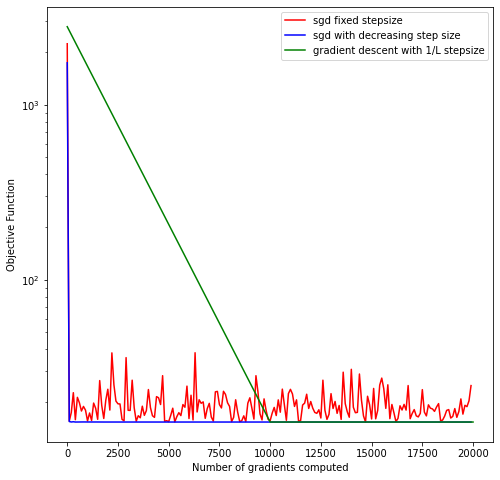

In [14]:
plt.figure(figsize=(8, 8))
plt.xlabel('Number of gradients computed')
plt.ylabel('Objective Function')
plt.yscale("log")
plt.plot(range(0,len(sgd_objectives),100),
         sgd_objectives[0:20000:100],'r', label='sgd fixed stepsize')
plt.plot(range(0,len(sgd_objectives_dec_gamma),100),
         sgd_objectives_dec_gamma[0:20000:100],'b', label='sgd with decreasing step size')
plt.plot(range(0,len(gradient_objectives)*10000,10000),
         gradient_objectives,'g', label='gradient descent with 1/L stepsize')
plt.legend(loc='upper right')
plt.show()

# Loading more complex data
The data is taken from https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength 

In [15]:
data = np.loadtxt("Concrete_Data.csv",delimiter=",")

A = data[:,:-1]
b = data[:,-1]
A, mean_A, std_A = standardize(A)

In [16]:
b.shape, A.shape

((1030,), (1030, 8))

# Running stochastic gradient descent

Test your SGD algorithm on the new dataset. Try different learning rates. Is the outcome very stable?

In [17]:
max_iters = 4000

gamma = 0.002 # Fill in a learning rate       

batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives, sgd_xs = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD: execution time=0.347 seconds


# Plotting the Evolution of the Objective Function

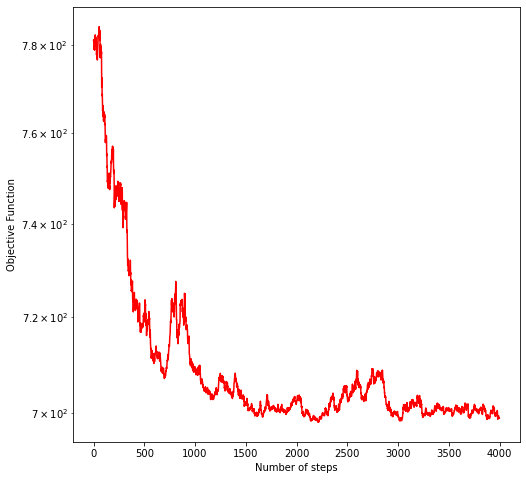

In [18]:
plt.figure(figsize=(8, 8))
plt.xlabel('Number of steps')
plt.ylabel('Objective Function')
plt.yscale("log")
plt.plot(range(len(sgd_objectives)), sgd_objectives,'r')

plt.show()

# Projected Stochastic Gradient Descant

To avoid $x$ becoming too big, we can perform constrained optimization by projecting x onto an $\text{L}_2$ ball at each iteration, thus limiting the norm of $x$.

Fill in the `projection` function below, which projects x onto an L2-ball:
(make sure the optimum is inside the l2-ball by choosing an appropriate radius)

In [29]:
l2_ball_radius = 100  # choose an appropriate radius
def projection(x):
    """project x onto an l2-ball"""
    norm = np.linalg.norm(x) 
    if norm > l2_ball_radius:
        x = x * (l2_ball_radius / norm)
    return x

Fill in the `projected_stochastic_gradient_descent` function below:<br>
(Hint: it is the same as stochastic_gradient_descent but with an extra step in the loop)

In [35]:
def projected_stochastic_gradient_descent(
        targets_b, 
        data_A, 
        initial_x, 
        batch_size, 
        max_iters, 
        initial_learning_rate,
        decreasing_learning_rate=False, 
        projection_fn=lambda x: x):

    """Projected gradient descent."""
    xs = []  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for iteration in range(max_iters):
        grad = stochastic_gradient(targets_b, data_A, x, batch_size=batch_size)
        if decreasing_learning_rate:
            lr = initial_learning_rate / (iteration + 1)
        else:
            lr = initial_learning_rate
            
        # update x through the stochastic gradient update
        x -= lr * grad
        
        # project onto the subset
        x = projection_fn(x)
            
        # store x and objective
        xs.append(x.copy())
        objective = full_objective(targets_b, data_A, x)
        objectives.append(objective)

#         print("SGD({bi}/{ti}): objective={l}".format(
#               bi=iteration, ti=max_iters - 1, l=objective))
    return objectives, xs

Test your projected SGD function

In [36]:
max_iters = 4000

gamma =  0.001# Fill in a learning rate      

batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
psgd_objectives, psgd_xs = projected_stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma,
    projection_fn=projection)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD: execution time=0.392 seconds


Plot the error

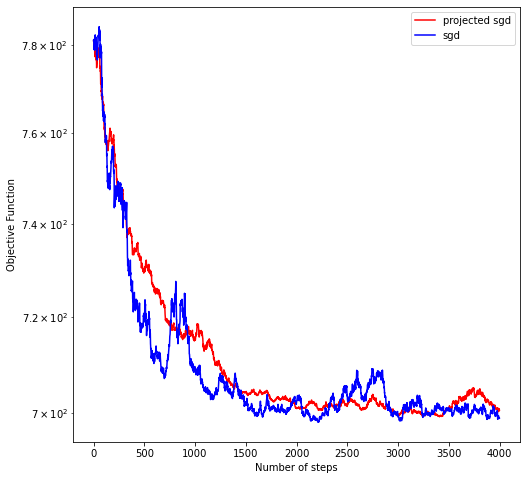

In [37]:
plt.figure(figsize=(8, 8))
plt.xlabel('Number of steps')
plt.ylabel('Objective Function')
plt.yscale("log")
plt.plot(range(len(psgd_objectives)), psgd_objectives,'r', label='projected sgd')
plt.plot(range(len(sgd_objectives)), sgd_objectives,'b', label='sgd')
plt.legend(loc='upper right')
plt.show()